### imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle
import os


### load training and testing sets

In [2]:
#if loaded train file exists
try:
    with open('data/train-data.pickle', 'rb') as handle:
        train = pickle.load(handle)
#if not load and save
except:
    !unzip data/training_set_VU_DM.csv.zip
    train = pd.read_csv('training_set_VU_DM.csv')
    !rm training_set_VU_DM.csv
    with open('data/train-data.pickle', 'wb') as handle:
        pickle.dump(train, handle)

#if loaded test file exists
try:
    with open('data/test-data.pickle', 'rb') as handle:
        test = pickle.load(handle)
#if not load and save
except:
    !unzip data/test_set_VU_DM.csv.zip
    test = pd.read_csv('test_set_VU_DM.csv')
    !rm test_set_VU_DM.csv
    with open('data/test-data.pickle', 'wb') as handle:
        pickle.dump(test, handle)

## Functions

### Submission

In [3]:
def create_submission(test_data, property_predicted_score, head=''):
    !mv submission.csv.zip prev.submission.zip
    test_data['raiting'] = property_predicted_score
    submition_data = test_data[['srch_id','prop_id','raiting']]
    submition_data = submition_data.sort_values(by=['srch_id', 'raiting'], ascending=[True,  False])
    submition_data = submition_data.drop(columns="raiting")
    file_name = head+'submission.csv'
    submition_data.to_csv(file_name, index=False)
    
    cmd = 'zip ' + file_name +'.zip ' + file_name
    os.system(cmd)
    os.system('rm ' + file_name)


### Ranking

In [4]:
def grades(data_frame):
    return data_frame['click_bool'] + data_frame['booking_bool']*4 #if booked then clicked, booked = 5

def discountedCumulativeGain(result, k=5):
    """
    Evaluated per query
    taken from 
    https://towardsdatascience.com/normalized-discounted-cumulative-gain-37e6f75090e9
    """
    dcg = []
    for idx, val in enumerate(result[0:k]): 
        #numerator = (2**val) - 1
        numerator = val
        # add 2 because python 0-index
        denominator =  np.log2(idx + 2) 
        score = numerator/denominator
        dcg.append(score)
    return sum(dcg)


def NDCG_at_k(X, ranking, grades, k=5, verbose=True):
    d = {'srch_id': X['srch_id'], 'ranking': ranking, 'grades': grades}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=['srch_id', 'ranking'], ascending=[True,  False])

    NDCG  = df.groupby('srch_id').aggregate\
    (ndcg=("grades", lambda x: discountedCumulativeGain(x, k)))

    df = df.sort_values(by=['srch_id', 'grades'], ascending=[True,  False])
    INDCG  = df.groupby('srch_id').aggregate\
    (indcg=("grades", lambda x: discountedCumulativeGain(x, k)))
    INDCG = INDCG[INDCG['indcg']!=0]
    x = NDCG['ndcg']/INDCG['indcg']# true ranking has the information regarding actual booking
    
    if verbose:
        print(f'ndcg_@{k} {x.mean()}')

    return x.mean()
# unit tests
d = {'srch_id': [1, 1, 1, 1, 1, 1]}
df = pd.DataFrame(data=d)
ndcg_score = NDCG_at_k(df, ranking=[5, 0, 0, 0, 0, 0], grades=[0, 0, 5, 0, 0, 0], k=5)

#assert discountedCumulativeGain([0,0,5], k=5)==((2**5-1)/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert discountedCumulativeGain([0,0,5], k=5)==(5/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert ndcg_score == (5/np.log2(4))/5 , "assertion ndcg wrong"


ndcg_@5 0.5


### Cross validation and model fit

In [5]:
def evaluate_model(model, X_train=[], X_test=[], features_to_choose=[], plot=False):
    rankings = my_fit_and_predict(model, X_train=X_train, X_test=X_test, \
                                  features_to_choose=features_to_choose, plot=plot)
    
    graded_relevance = X_test['grades']
    #graded_relevance = grades(data_frame=X_test)
    
    ndcg_score = NDCG_at_k(X_test, ranking=rankings, grades=graded_relevance, k=5, verbose=False)
    return ndcg_score

def my_fit_and_predict(model, X_train=[], X_test=[], features_to_choose=[], plot=False):
    
    Y = X_train['grades']
    #Y = target_function(data_frame=X_train)
    #X_train, X_test = cross_hotel_booking_likelihood(X_train, X_test)
    
    #X_train = KFoldTargetEncoderTest(X=X_train)
    #X_test = join_test_and_train_Kfold(train=X_train, test=X_test)
    
    model.fit(X_train[features_to_choose], Y)
        
    if plot:
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + 0.5
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.barh(pos, feature_importance[sorted_idx], align="center")
        plt.yticks(pos, np.array(features_to_choose)[sorted_idx])
        plt.title("Feature Importance (MDI)")

    rankings = model.predict(X_test[features_to_choose])

    return rankings 


def my_cross_validation(model, X=[], features_to_choose=[], n_splits=5):
    kfold = KFold(n_splits=n_splits)
    ndcg_score = 0
    for train, test in kfold.split(X):
        X_train, X_test = X.iloc[train, :], X.iloc[test, :]
        ndcg_score += evaluate_model(model, X_train, X_test, features_to_choose)
    
    average = ndcg_score/n_splits
    print(f'cross_validation average {average}')
    return average

"""def my_cross_validation(model, X=[], features_to_choose=[], n_splits=5):
    kfold = KFold(n_splits=n_splits)
    ndcg_score = 0
    
    search_id = X[['srch_id']]
    search_id = search_id.drop_duplicates()
     
    for train_idx, eval_idx in kfold.split(search_id):
        search_id_train = search_id.iloc[train_idx,:]
        search_id_eval = search_id.iloc[eval_idx,:]
        
        X_train = search_id_train.merge(X, how='left', left_on='srch_id', right_on='srch_id')
        X_eval = search_id_eval.merge(X, how='left', left_on='srch_id', right_on='srch_id')
        ndcg_score += evaluate_model(model, X_train, X_eval, features_to_choose)
    
    average = ndcg_score/n_splits
    print(f'cross_validation average {average}')
    return average"""

"def my_cross_validation(model, X=[], features_to_choose=[], n_splits=5):\n    kfold = KFold(n_splits=n_splits)\n    ndcg_score = 0\n    \n    search_id = X[['srch_id']]\n    search_id = search_id.drop_duplicates()\n     \n    for train_idx, eval_idx in kfold.split(search_id):\n        search_id_train = search_id.iloc[train_idx,:]\n        search_id_eval = search_id.iloc[eval_idx,:]\n        \n        X_train = search_id_train.merge(X, how='left', left_on='srch_id', right_on='srch_id')\n        X_eval = search_id_eval.merge(X, how='left', left_on='srch_id', right_on='srch_id')\n        ndcg_score += evaluate_model(model, X_train, X_eval, features_to_choose)\n    \n    average = ndcg_score/n_splits\n    print(f'cross_validation average {average}')\n    return average"

### Target and Likelihood

In [6]:
def target_function(data_frame):
    #lklhd = hotel_booking_likelihood(data_frame)
    #data_frame_out = data_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    #x = data_frame['lklhd'].values #0.26-0.28
    #x = grades(data_frame) + data_frame['lklhd'].values #same as grading 1 click 5 book
    #x = grades(data_frame) 
    x = data_frame['grades'] 
    
    #x = (data_frame['click_bool'] + data_frame['booking_bool']*4)*np.log2(data_frame['position'] + 2) + data_frame['lklhd'].values
    #x = (data_frame['click_bool'] + 4*data_frame['booking_bool'])*(data_frame['position'] + 1)*(1+data_frame['lklhd'].values)#*(data_frame['gross_bookings_usd']+1) 

    return x


        

def hotel_booking_likelihood(data_frame=[]):
    """"""
    lklhd = data_frame.groupby('prop_id').sum().reset_index()
    lklhd = lklhd[['prop_id','booking_bool', 'click_bool']]
    
    lklhd['lklhd'] = lklhd['booking_bool'] + lklhd['click_bool']
    
    counts = data_frame.groupby('prop_id').size().reset_index(name='counts')
    
    # normalize by total counts of total amounts prop_id
    lklhd['lklhd'] = lklhd['lklhd']/counts['counts']
    lklhd.drop(columns=['booking_bool', 'click_bool'], inplace=True)
 
    return lklhd

def cross_hotel_booking_likelihood(train_frame, test_frame):
    x = test['prop_id']
    y = train['prop_id']
    common = set(x).intersection(set(y))
    
    lklhd = hotel_booking_likelihood(data_frame=train_frame)
    
    x = train_frame['prop_id']
    y = test_frame['prop_id']
    
    # evaluate the likelihood only for the interesection of hotels
    common = list(set(x).intersection(set(y)))
    commonDf = pd.DataFrame({'prop_id':common})
    
    lklhd_intersection = commonDf.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    train_frame_out = train_frame.merge(lklhd_intersection, how='left', left_on='prop_id', right_on='prop_id')
    test_frame_out = test_frame.merge(lklhd_intersection, how='left', left_on='prop_id', right_on='prop_id')
    
    #apply value to "nones" values
    median_lklhd = test_frame_out['lklhd'].median()
    
    mask  = test_frame_out['lklhd'].isnull()
    test_frame_out.loc[mask, 'lklhd'] =  median_lklhd
    mask  = train_frame_out['lklhd'].isnull()
    train_frame_out.loc[mask, 'lklhd'] = median_lklhd
    
    assert len(test_frame_out)==len(test_frame)
    assert len(train_frame_out)==len(train_frame)
    assert test_frame_out['lklhd'].isnull().sum() == 0
    return train_frame_out, test_frame_out


# unit tests
train_unit = pd.DataFrame({'srch_id':[1,1,1,2,2,2,3,3,3], 
                           'prop_id':[1,2,3,1,2,3,1,2,3],
                      'booking_bool':[1,0,0,1,0,0,0,0,1],
                        'click_bool':[1,0,1,1,0,0,0,0,1]})

test_unit = pd.DataFrame({'srch_id':[1,1,1,2,2,2,3,3,3], 
                          'prop_id':[1,2,4,1,2,4,1,2,4],
                     'booking_bool':[1,0,0,1,0,0,0,0,1],
                       'click_bool':[1,0,1,1,0,0,0,0,1]})

lklhd = hotel_booking_likelihood(data_frame=train_unit)
#display(lklhd)
#display(train_unit)
mask=train_unit['prop_id']==1
#display(train_unit[mask])
assert lklhd.loc[0, 'lklhd'] == 4/3
assert lklhd.loc[2, 'lklhd'] == 1

train_unit_out, test_unit_out = cross_hotel_booking_likelihood(train_unit, test_unit)
#display(train_unit_out)

assert train_unit_out.loc[2, 'lklhd'] == 2/3#median value
assert test_unit_out.loc[2, 'lklhd'] == 2/3

train_unit['grades'] = grades(train_unit)
#a = KFoldTargetEncoderTest(X=train_unit)

#b = join_test_and_train_Kfold(train=a, test=test_unit )





### features engeneering

In [7]:
def features_engeneering(data_frame):
    data_frame['month'] = pd.DatetimeIndex(pd.to_datetime(data_frame['date_time'])).month
    data_frame = data_frame.sort_values(by=['srch_id', 'price_usd'], ascending=[True,  False])#.reset_index(drop=True)
    data_frame['price_order'] = data_frame.groupby('srch_id').cumcount()

    for i in ['orig_destination_distance']:
        data_frame[i] = data_frame[i].fillna(100)#(data_frame[i].max())
    
    for i in ['prop_review_score', 'prop_location_score2']:#, 'comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']:
        data_frame[i] = data_frame[i].fillna(-1)
    
     
    data_frame = is_cheaper(data_frame)
    
    min_affinity = data_frame['srch_query_affinity_score'].min()
    data_frame['srch_query_affinity_score'] = data_frame['srch_query_affinity_score'].fillna(min_affinity)
    
    
    price_per_country_median = data_frame.groupby('prop_country_id').median().reset_index()
    price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
    price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
    
    price_per_query_max = data_frame.groupby('srch_id').max().reset_index()
    price_per_query_max = price_per_query_max[['srch_id','price_usd']]
    price_per_query_max = price_per_query_max.rename(columns={"price_usd": "price_per_query_max"})

    data_frame = data_frame.merge(price_per_country_median, how='left', left_on='prop_country_id', right_on='prop_country_id')
    data_frame = data_frame.merge(price_per_query_max, how='left', left_on='srch_id', right_on='srch_id')
    
    # apply maximum price for missing values
    mask = data_frame['price_usd'] == 0
    data_frame.loc[mask, 'price_usd'] = data_frame.loc[mask, 'price_per_query_max']
    
    mask_log_0 = data_frame['prop_log_historical_price']==0 #no data assume same price
 
    data_frame['delta_log_price'] = np.log(data_frame['price_usd']) - data_frame['prop_log_historical_price']
    data_frame.loc[mask_log_0, 'delta_log_price'] = 0
     
    # normalization
    data_frame['price_usd_normalized'] = data_frame['price_usd']/data_frame['price_per_country_median']
    
    # normalise by number of persons
    number_of_person = (data_frame['srch_adults_count'] + data_frame['srch_children_count']/2)
    data_frame['price_per_person'] = data_frame['price_usd']/number_of_person
    
    return data_frame

def undersample(data_frame, number_of_lines):
    """ 
    Keeps first number_of_lines in the 
    group srch_id and removes the rest"""
    data_frame = data_frame.sort_values(by=['srch_id', 'booking_bool', 'click_bool'], ascending=[True,  False, False]).reset_index(drop=True)
    df = data_frame[['srch_id']]
    x = df.groupby('srch_id').cumcount()# cummulative counting of group members
    data_frame.loc[:, 'group_index'] = x
    mask = data_frame['group_index']<number_of_lines
    data_frame = data_frame[mask]
    data_frame = data_frame.reset_index(drop=True)
    data_frame = data_frame.sort_values(by=['srch_id', 'booking_bool', 'click_bool'], ascending=[True,  False, False]).reset_index(drop=True)
    data_frame.drop(columns='group_index', inplace=True)

    return data_frame

""" unit test undersample """
data_frame_test = pd.DataFrame({ 'prop_id' : range(1, 11),\
                                'srch_id':[1, 1, 1, 1, 1, 1, 2, 2, 2, 2], \
                          'booking_bool': [0, 0, 0, 0, 0 ,1, 0, 0, 0, 0],
                            'click_bool': [0, 0, 0, 0, 1 ,1, 0, 0, 1, 0]})
df_test_out = pd.DataFrame({'prop_id' : [6, 5, 1, 2, 9, 7, 8, 10 ],
                             'srch_id': [1, 1, 1, 1 ,2, 2, 2, 2], 
                        'booking_bool': [1, 0, 0, 0, 0 ,0, 0, 0], 
                          'click_bool': [1, 1, 0, 0, 1 ,0, 0, 0]})
def is_cheaper(df):
    #+1 if Expedia has a lower price than competitor ; 0 if the same; -1 if Expedia’s
    #price is higher than competitor 1; null signifies there is no competitive data
    
    # Drop all other comp columns, except for "rate"
    df = df.drop(df.filter(regex='(comp._inv|comp._rate.+)').columns, axis=1)
    # Create new col
    df['comp_cheaper'] = np.nan
    #df['exp_cheaper'] = np.nan
    
    df_filter_comp = df.filter(regex='comp') 
    #df['comp_cheaper'] = df['comp_cheaper'].mask((df_filter_comp== 0).any(axis=1),0).mask((df_filter_comp < 0).any(axis=1), -1).mask((df_filter_comp>0).any(axis=1), 1)
    df['comp_cheaper'] = df['comp_cheaper'].mask((df_filter_comp == 0).any(axis=1),0).mask((df_filter_comp > 0).any(axis=1), 1).mask((df_filter_comp<0).any(axis=1), -1)
    #df['comp_cheaper'] = df['comp_cheaper'].mask((df_filter_comp < 0).any(axis=1), -1)
    #df['exp_cheaper'] = df['exp_cheaper'].mask((df_filter_comp > 0).any(axis=1), 1)
    # Drop old comp cols
    df = df.drop(df.filter(regex='comp._rate').columns, axis=1)
    df['comp_cheaper'] = df['comp_cheaper'].fillna(0)
    #df['exp_cheaper'] = df['exp_cheaper'].fillna(0)

    #if expedia is cheaper then put 1, but if yet there is a competitor cheaper override with -1
    #df_filter_comp = df.filter(regex='cheaper') 
    #df['comp_combined'] = np.nan
    #df['comp_combined'] = df['comp_cheaper'].mask((df_filter_comp>0).any(axis=1),1).mask((df_filter_comp < 0).any(axis=1), -1)

    return df


df = pd.DataFrame({'comp1_rate':[0, 0, 0, 0 ],'comp2_rate': [1 ,-1, 1, 0], 'comp3_rate':[-1, 0, 0, np.nan]})

df=is_cheaper(df)

display(df)


assert df['comp_cheaper'].loc[0]==-1
assert df['comp_cheaper'].loc[1]==-1
assert df['comp_cheaper'].loc[2]==1
assert df['comp_cheaper'].loc[3]==0

df_out = undersample(data_frame_test, 4)                             
check = df_test_out==df_out
assert check.values.prod()==True, 'undersample failed'



,comp_cheaper
0,-1.0
1,-1.0
2,1.0
3,0.0


### Total columns

In [8]:
train['grades'] = grades(train)

train_amount = len(train)
print(f'train length: {train_amount}')
print(f'test length: {len(test)}')
mask = train['booking_bool']==True
booked_amount = len(train[mask])
print(f'booked amount: {booked_amount}')
mask = (train['booking_bool']==False) & (train['click_bool']==True)
clicked_amount = len(train[mask])
print(f'clicked but not booked: {clicked_amount}')
print(f'total/booked: {train_amount/booked_amount}')
print(f'columns: {len(train.columns)}')


train length: 4958347
test length: 4959183
booked amount: 138390
clicked but not booked: 83489
total/booked: 35.82879543319604
columns: 55


In [9]:
def KFoldTargetEncoderTest(X=[], n_splits=5 ):
    kfold = KFold(n_splits=n_splits)
    col_mean_name = 'kfold_lklhd'
    
    X['kfold_lklhd'] = np.nan
    mean_of_target = X['grades'].mean()
    
    search_id = X[['srch_id']]
    search_id = search_id.drop_duplicates()
      
    
    for tr_ind, val_ind in kfold.split(search_id):
        search_id_train = search_id.iloc[tr_ind,:]
        search_id_eval = search_id.iloc[val_ind,:]
        
        X_tr = search_id_train.merge(X, how='left', left_on='srch_id', right_on='srch_id')
        X_val = search_id_eval.merge(X, how='left', left_on='srch_id', right_on='srch_id')
        
        lklhd = X_tr.groupby('prop_id')['grades'].mean().reset_index() 
        data = X.loc[X.index[val_ind], [col_mean_name]]
        X.loc[X.index[val_ind], [col_mean_name]] =\
        data.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
        X[col_mean_name].fillna(mean_of_target, inplace = True)
    
    return X

def join_test_and_train_Kfold(train=[], test=[] ):
    lklhd =  train[['prop_id', 'kfold_lklhd']].groupby('prop_id').mean().reset_index() 
    display(lklhd)
    display(test)

    mean_of_target = train['grades'].mean()
    test_frame_out = test.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')

    test_frame_out['kfold_lklhd'].fillna(mean_of_target, inplace = True)

    return test_frame_out


In [10]:
#KFoldTargetEncoderTest(X=train, n_splits=5 )

### Total null columns and filling nulls in train

In [11]:
mask = train['booking_bool'] == True
train.loc[mask,['prop_location_score1', 'prop_location_score2']].max()

prop_location_score1    6.97
prop_location_score2    1.00
dtype: float64

## Parameters
defines parameters for running the training and predictions

In [12]:
max_price_usd = train['price_usd'].median() + train['price_usd'].std()*5
max_price_usd = 1e9
keep_first_lines = 5
perform_undersampling = False
perform_submission = True
number_of_splits = 5

print(f'max allowed price {max_price_usd} $')
print(f'perform_submission {perform_submission} ')
print(f'perform_undersampling {perform_undersampling} ')


max allowed price 1000000000.0 $
perform_submission True 
perform_undersampling False 


### Amount of hotels in data sets

In [13]:
x = test['prop_id']
y = train['prop_id']
unique_test = set(x) - set(y)
unique_train = set(y) - set(x)
common = set(x).intersection(set(y))
print(f'Amount of hotels in test data {len(set(x))} ')
print(f'Amount of hotels in train data {len(set(y))}')
print(f'Amount of unique hotels test {len(unique_test)}')
print(f'Amount of unique hotels train {len(unique_train)}')
print(f'Amount of common hotels in train and  test {len(common)}')

#train['prop_id']==unique


Amount of hotels in test data 129438 
Amount of hotels in train data 129113
Amount of unique hotels test 7773
Amount of unique hotels train 7448
Amount of common hotels in train and  test 121665


0.05421686746987952

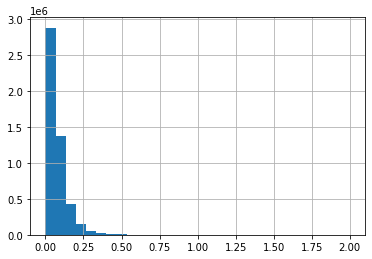

In [14]:
tr, te = cross_hotel_booking_likelihood(train, test)
x = tr['lklhd']#hotel_booking_likelihood(train)

tr['lklhd'].hist(bins=30)
tr['lklhd'].median()



In [15]:
#kfld = KFoldTargetEncoderTest(X=train, n_splits=5 )

In [16]:
#print(kfld.isnull().sum())


In [17]:
print(train.isnull().sum())


srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

In [18]:
train_eng = features_engeneering(train)
test_eng = features_engeneering(test)

train_eng = train_eng.dropna(axis=1)

assert len(train_eng)==len(train)
assert len(test_eng)==len(test)

if perform_undersampling:
    train_eng = undersample(train_eng, keep_first_lines) 
    ## remove outliers from price
mask = train_eng['price_usd']<max_price_usd
train_eng = train_eng[mask]

a = set(train_eng.columns)
len(a)
b = set(test_eng.columns)
print(f'columns not in both sets {a-b}')




columns not in both sets {'booking_bool', 'grades', 'click_bool', 'position'}


In [19]:
#train_eng['prop_id'].map(train_eng.groupby('prop_id')['grades'].mean())
#len(train_eng.groupby('prop_id')['grades'].mean())

In [20]:
#mask=train_eng['booking_bool']==True
#train_eng.loc[mask,'comp_combined'].hist()

12

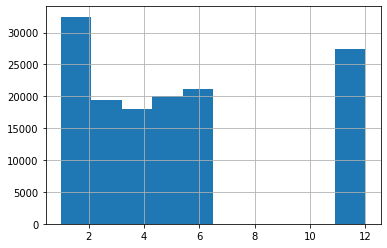

In [21]:
mask = train_eng['booking_bool']==True
train_eng.loc[mask, 'month'].hist()
train_eng['month'].max()

In [22]:
display(train_eng[['month', 'delta_log_price', 'price_usd','booking_bool', 'price_order','price_per_country_median','price_per_query_max','price_per_person']].head(100))

,month,delta_log_price,price_usd,booking_bool,price_order,price_per_country_median,price_per_query_max,price_per_person
0,4,2.011536,602.77,0,0,119.0,602.77,150.6925
1,4,0.487251,280.69,0,1,119.0,602.77,70.1725
2,4,0.321100,210.84,0,2,119.0,602.77,52.7100
3,4,0.074639,195.32,0,3,119.0,602.77,48.8300
4,4,-0.025426,191.44,0,4,119.0,602.77,47.8600
...,...,...,...,...,...,...,...,...
95,2,-0.257349,85.00,0,9,119.0,153.00,42.5000
96,2,-0.197349,85.00,0,10,119.0,153.00,42.5000
97,2,-0.739183,84.00,0,11,119.0,153.00,42.0000
98,2,-0.519183,84.00,0,12,119.0,153.00,42.0000


### Choose features to fit

In [23]:
print(train_eng.columns)#  the columns after droping


features_to_choose = [#'srch_id', 
                      #'date_time',
                      #'site_id',
                      'visitor_location_country_id',
                      'prop_country_id',
                      'prop_id',
                      'prop_starrating',
                      'prop_review_score',
                      'prop_brand_bool',
                      'prop_location_score1',
                      'prop_location_score2',
                      'prop_log_historical_price',
                      #'position',
                      'price_usd',
                      #'price_usd_normalized',
                      'promotion_flag',
                      'srch_destination_id',
                      'srch_length_of_stay',
                      'srch_booking_window',
                      'srch_adults_count',
                      'srch_children_count',
                      'srch_room_count',
                      'srch_saturday_night_bool',
                      'orig_destination_distance',
                      'random_bool',
                      #'click_bool',
                      #'gross_bookings_usd',
                      #'booking_bool',
                      #'location_score',
                      #'historical_price',
                      #'price_per_country_median',
                      #'price_per_person'
                      #'price_order',
                      #'lklhd',
                      #'month'
                      'delta_log_price',
                      'comp_cheaper',
                      #'srch_query_affinity_score'
                                             ]                        
missing_values = set(train_eng.columns) - set(features_to_choose)
print(f'not used fields {missing_values}')

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'click_bool',
       'booking_bool', 'grades', 'month', 'price_order', 'comp_cheaper',
       'price_per_country_median', 'price_per_query_max', 'delta_log_price',
       'price_usd_normalized', 'price_per_person'],
      dtype='object')
not used fields {'date_time', 'price_per_person', 'srch_query_affinity_score', 'price_usd_normalized', 'grades', 'position', 'booking_bool', 'month', 'click_bool', 'price_per_country_median', 'srch_

In [24]:
#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules
#frequent_itemsets= apriori(df[['promotion_flag','srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool']], min_support=0.07, use_colnames=True)
#rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#rules = rules.sort_values(by=[ 'support', 'confidence',], ascending=False)

#rules[['antecedents', 'consequents','support','confidence']].iloc[0:10]


## Test and Evaluate

In [25]:
loss_function = 'absolute_error'
loss_function = 'squared_error'
#{‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}

In [26]:
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit regression model
#model = linear_model.LinearRegression()
#n_neighbors = 10
#model = neighbors.KNeighborsRegressor(n_neighbors)
#model= DecisionTreeRegressor(random_state=0)
#model = GradientBoostingRegressor(random_state=0)

########       Cross EVALUATION           ###############

"""


train_idx = int(len(train_eng)*1/2)
evaluation_size = int(train_idx*size)

X_train = train_eng.iloc[0:(train_idx-evaluation_size), :]
X_eval = train_eng.iloc[(train_idx-evaluation_size):train_idx, :]
X_test = train_eng.iloc[train_idx:, :]
"""
evaluation_set_size = 0.05
test_set_size = 0.5

search_id = train_eng[['srch_id']]
search_id = search_id.drop_duplicates()
X_train, X_test = train_test_split(search_id, test_size=test_set_size, random_state=42)
X_train, X_eval = train_test_split(X_train, test_size=evaluation_set_size, random_state=42)

X_train = X_train.merge(train_eng, how='left', left_on='srch_id', right_on='srch_id')
X_eval = X_eval.merge(train_eng, how='left', left_on='srch_id', right_on='srch_id')
X_test = X_test.merge(train_eng, how='left', left_on='srch_id', right_on='srch_id')


In [27]:
import xgboost as xgb
modelXGBRegressor = xgb.XGBRegressor(eval_metric=["ndcg@5"])
# Fit the model using predictor X and response y.
start = time.time()
ndcg_score = evaluate_model(modelXGBRegressor, X_train, X_test, features_to_choose)
end = time.time()
print(f'Validation time and score RandomForestRegressor: {end-start}, {ndcg_score}')

Validation time and score RandomForestRegressor: 134.12165236473083, 0.35399632471365816


In [28]:
start = time.time()
raitings  = my_fit_and_predict(modelXGBRegressor, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit XGBRegressor:", end-start)
create_submission(test_eng, raitings, 'XGBRegressor')
assert len(raitings)==len(test)
features_to_choose

The time of final fit XGBRegressor: 301.4353404045105
mv: cannot stat 'submission.csv.zip': No such file or directory
updating: XGBRegressorsubmission.csv (deflated 67%)


['visitor_location_country_id',
 'prop_country_id',
 'prop_id',
 'prop_starrating',
 'prop_review_score',
 'prop_brand_bool',
 'prop_location_score1',
 'prop_location_score2',
 'prop_log_historical_price',
 'price_usd',
 'promotion_flag',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_booking_window',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'srch_saturday_night_bool',
 'orig_destination_distance',
 'random_bool',
 'delta_log_price',
 'comp_cheaper']

### RandomForestRegressor

#### cross validation

cross_validation average 0.25070034835830884
The time of evaluation fit: 16.466878414154053
cross_validation average 0.32046545937002635
The time of evaluation fit: 27.715214252471924
cross_validation average 0.3244481896219201
The time of evaluation fit: 36.734994888305664
cross_validation average 0.3180377989694829
The time of evaluation fit: 52.08598709106445
exit before the end
Optimal depth: 7
score: 0.3244481896219201


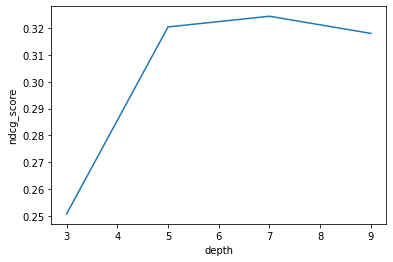

In [29]:
x = []
depth = [x for x in range(3,15) if x % 2 != 0]
prev_ndgc = 0
for i in depth:
    start = time.time()
    model = RandomForestRegressor(max_depth=i, criterion=loss_function, random_state=0, n_jobs=-1)
    ndcg_score = my_cross_validation(model, X=X_eval, features_to_choose=features_to_choose, n_splits=number_of_splits)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_depth = depth[optimal_score_index]
print(f'Optimal depth: {optimal_depth}')
print(f'score: {max(x)}')

plt.plot(depth[0:len(x)], x)
plt.xlabel('depth')
plt.ylabel('ndcg_score')
plt.show()

### GradientBoostingRegressor

cross_validation average 0.3134415249950078
The time of evaluation fit: 25.706979274749756
cross_validation average 0.3312802612832487
The time of evaluation fit: 37.85343956947327
cross_validation average 0.3376246682316115
The time of evaluation fit: 49.60373878479004
cross_validation average 0.3402625732683018
The time of evaluation fit: 73.7836492061615
cross_validation average 0.3408555981324063
The time of evaluation fit: 85.56842827796936
cross_validation average 0.3405582223758539
The time of evaluation fit: 109.13006711006165
exit before the end
Optimal n estimators: 70
score: 0.3408555981324063


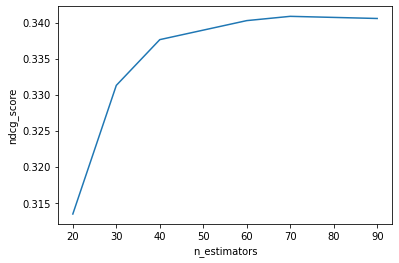

In [30]:
x = []
n_estimators = [20, 30, 40, 60, 70, 90, 100, 110, 120, 130]
prev_ndgc = 0
for i in n_estimators:
    start = time.time()
    model = GradientBoostingRegressor(loss=loss_function, n_estimators = i, random_state=0)
    ndcg_score = my_cross_validation(model, X_eval, \
                features_to_choose, n_splits=number_of_splits)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_n = n_estimators[optimal_score_index]
print(f'Optimal n estimators: {optimal_n}')
print(f'score: {max(x)}')
plt.plot(n_estimators[0:len(x)], x)
plt.xlabel('n_estimators')
plt.ylabel('ndcg_score')
plt.show()


### Testing Random Forest

In [32]:
##
start = time.time()
model_random_forest = RandomForestRegressor(max_depth=optimal_depth, criterion=loss_function, random_state=0, n_jobs=-1)
ndcg_score = evaluate_model(model_random_forest, X_train, X_test, features_to_choose)
end = time.time()
print(f'Validation time and score RandomForestRegressor: {end-start}, {ndcg_score}')

Validation time and score RandomForestRegressor: 299.1535539627075, 0.32765053306359504


### Testing Gradient Boosting

Validation time and score GradientBoostingRegressor: 530.2573828697205, 0.34605946657402414


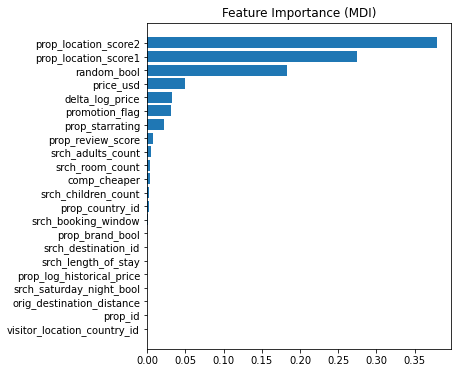

In [33]:
start = time.time()
model_gradient_boosting = GradientBoostingRegressor(n_estimators=optimal_n,loss=loss_function, random_state=0)
ndcg_score = evaluate_model(model_gradient_boosting, X_train, X_test, features_to_choose, plot=True)
end = time.time()
print(f'Validation time and score GradientBoostingRegressor: {end-start}, {ndcg_score}')

## Fit and submit 

In [34]:
assert perform_submission

### GradientBoostingRegressor

In [ ]:
start = time.time()
raitings  = my_fit_and_predict(model_gradient_boosting, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit GradientBoostingRegressor:", end-start)
create_submission(test_eng, raitings, 'GradientBoostingRegressor')
assert len(raitings)==len(test)
features_to_choose

### RandomForestRegressor

In [ ]:
start = time.time()
raitings = my_fit_and_predict(model_random_forest, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit RandomForestRegressor:", end-start)
create_submission(test_eng, raitings, 'RandomForestRegressor')
assert len(raitings)==len(test)
features_to_choose

In [ ]:
len(raitings)

In [ ]:
display(raitings)

In [ ]:
features_to_choose